# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import sys
sys.path.append('/gdrive/My Drive/Colab Notebooks/assignment1')

from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [0]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = '/gdrive/My Drive/Colab Notebooks/assignment1/cs231n/datasets/cifar-10-batches-py'

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your interests.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [4]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [0]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
from itertools import product
for lr, reg in product(learning_rates, regularization_strengths):
  svm = LinearSVM()
  svm.train(X_train_feats, y_train, learning_rate=lr, num_iters=800,
            reg=reg, batch_size=200, verbose=False)
  train_pred = svm.predict(X_train_feats)
  val_pred = svm.predict(X_val_feats)
  val_accuracy = np.mean(val_pred == y_val)
  results[(lr, reg)] = (np.mean(train_pred == y_train),
                        np.mean(val_pred == y_val))
  if val_accuracy > best_val:
    best_val = val_accuracy
    best_svm = svm
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-09 reg 5.000000e+04 train accuracy: 0.091816 val accuracy: 0.078000
lr 1.000000e-09 reg 5.000000e+05 train accuracy: 0.112571 val accuracy: 0.100000
lr 1.000000e-09 reg 5.000000e+06 train accuracy: 0.144918 val accuracy: 0.142000
lr 1.000000e-08 reg 5.000000e+04 train accuracy: 0.106184 val accuracy: 0.106000
lr 1.000000e-08 reg 5.000000e+05 train accuracy: 0.310061 val accuracy: 0.298000
lr 1.000000e-08 reg 5.000000e+06 train accuracy: 0.405735 val accuracy: 0.421000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.414041 val accuracy: 0.423000
lr 1.000000e-07 reg 5.000000e+05 train accuracy: 0.404327 val accuracy: 0.417000
lr 1.000000e-07 reg 5.000000e+06 train accuracy: 0.312306 val accuracy: 0.338000
best validation accuracy achieved during cross-validation: 0.423000


In [0]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.423


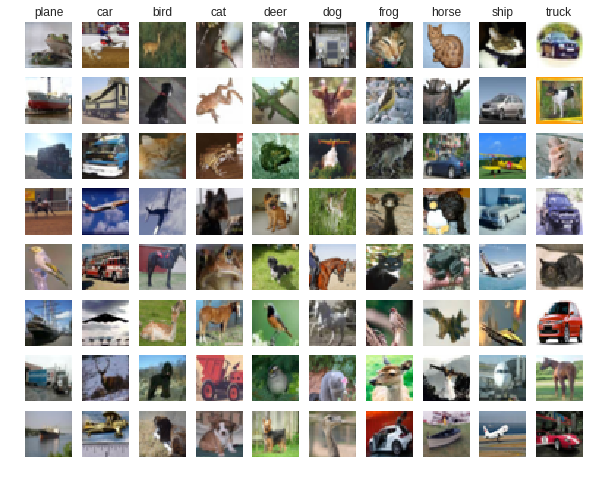

In [0]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

I think that misclassification occure due very similar HOGs of images.

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [0]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [0]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

In [0]:
from collections import defaultdict
def train_different_params(X_train, y_train,
                           X_val, y_val,
                           params, params_to_tune):
  history = defaultdict(dict)
  for key in params_to_tune:
    for value in params_to_tune[key]:
      params[key] = value
      model = TwoLayerNet(input_dim, hidden_dim, num_classes)
      history[key][value] = model.train(X_train, y_train, X_val, y_val, **params)
  return history

In [0]:
hist = train_different_params(X_train_feats, y_train, X_val_feats, y_val,
                              params = {
                                  'verbose': True,
                                  'batch_size': 200,
                                  'learning_rate': 0.05, #[0.01, 0.1]
                                  'num_iters': 1,
                                  'learning_rate_decay': 1
                              },
                              params_to_tune = {
                                  'reg': [0.005, 0.0005]
                              }
                             )

iteration 0 / 600: loss 2.302589
iteration 100 / 600: loss 2.301596
iteration 200 / 600: loss 2.303034
iteration 300 / 600: loss 2.286205
iteration 400 / 600: loss 2.111393
iteration 500 / 600: loss 1.951033
iteration 0 / 600: loss 2.302585
iteration 100 / 600: loss 2.302882
iteration 200 / 600: loss 2.301765
iteration 300 / 600: loss 2.276181
iteration 400 / 600: loss 2.081668
iteration 500 / 600: loss 1.919605


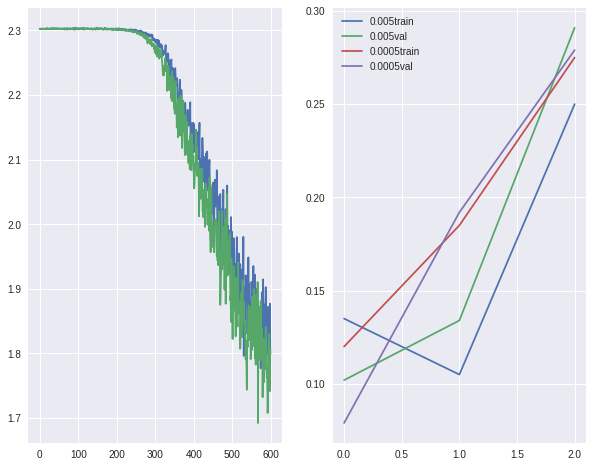

In [0]:
plt.subplot(1, 2, 1)
# plt.title('loss')
for value in hist['reg']:
  plt.plot(hist['reg'][value]['loss_history'], label=value)
  
plt.subplot(1, 2, 2)
# plt.title('Accuracy')
for value in hist['reg']:
  plt.plot(hist['reg'][value]['train_acc_history'], label=str(value) + 'train')
  plt.plot(hist['reg'][value]['val_acc_history'], label=str(value) + 'val')
  

plt.legend()

In [0]:
from hyperopt import fmin, hp, tpe, STATUS_OK, Trials
import time

In [0]:
best_net = None
max_val_score = 0

def objective(params):
  global best_net, max_val_score
  print(params)
  
  before = time.time()
  
  net = TwoLayerNet(input_dim, hidden_dim, num_classes)
  train_history = net.train(X_train_feats, y_train, X_val_feats, y_val, 
                            *params, verbose=True)
  
  now = time.time()
  pred = (net.predict(X_val_feats) == y_val).mean()
  
  if pred > max_val_score:
    best_net = net
  
  return {
      'loss': -pred,
      'status': STATUS_OK, 
      'execution_time': now - before,
      'attachments': {
          'history': train_history
      },
  }

In [0]:
space = [
    hp.uniform('learning_rate', 1e-1, 5e-1),
    hp.uniform('learning_rate_decay', 0.75, 1),
    hp.uniform('reg', 1e-4, 3e-2),
    hp.choice('num_iters', [1600]),
    hp.choice('batch_size', [200]),
]

In [48]:
%%time
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            trials=trials,
            max_evals=10,
           )

(0.4618697996387964, 0.8590374909385997, 0.014682388423157918, 1600, 200)
iteration 0 / 1600: loss 2.302598
iteration 100 / 1600: loss 1.796525
iteration 200 / 1600: loss 1.726598
iteration 300 / 1600: loss 1.721426
iteration 400 / 1600: loss 1.691295
iteration 500 / 1600: loss 1.714645
iteration 600 / 1600: loss 1.632966
iteration 700 / 1600: loss 1.640503
iteration 800 / 1600: loss 1.617982
iteration 900 / 1600: loss 1.618397
iteration 1000 / 1600: loss 1.629095
iteration 1100 / 1600: loss 1.706016
iteration 1200 / 1600: loss 1.690604
iteration 1300 / 1600: loss 1.616601
iteration 1400 / 1600: loss 1.626393
iteration 1500 / 1600: loss 1.581099
(0.46200866203349533, 0.9539140380000065, 0.020778048920393012, 1600, 200)
iteration 0 / 1600: loss 2.302602
iteration 100 / 1600: loss 1.889488
iteration 200 / 1600: loss 1.856363
iteration 300 / 1600: loss 1.768106
iteration 400 / 1600: loss 1.737200
iteration 500 / 1600: loss 1.811316
iteration 600 / 1600: loss 1.742387
iteration 700 / 1600:

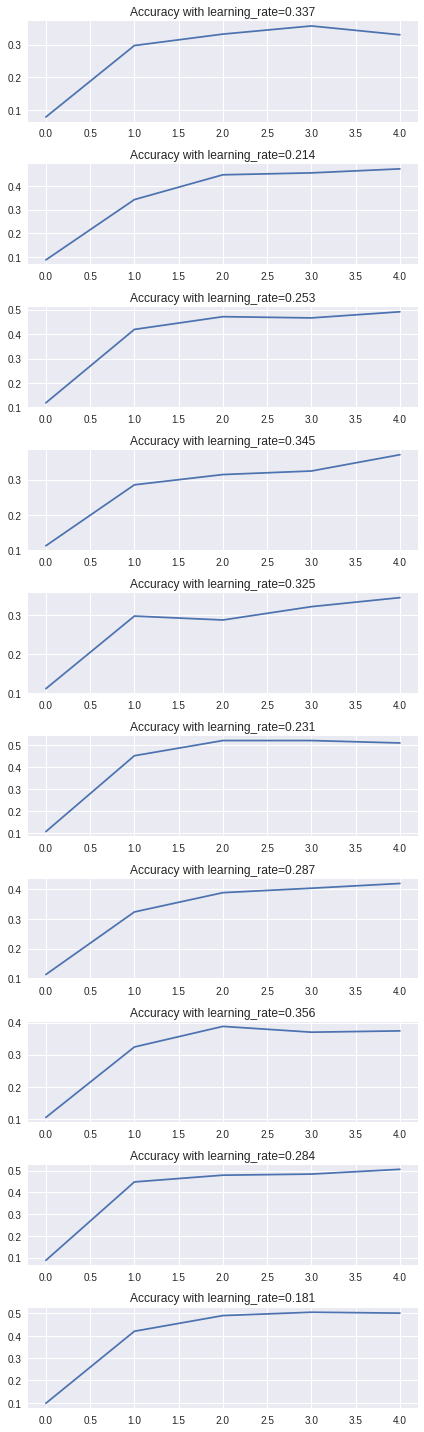

In [46]:
plt.figure(figsize=(6,20))
plots = len(trials.trials)
for i, trial in enumerate(trials.trials):
  plt.subplot(plots, 1, i+1)
  plt.plot(trials.trial_attachments(trial)['history']['val_acc_history'], )
  plt.title('Accuracy with learning_rate=' + str(round(trial['misc']['vals']['learning_rate'][0], 3)))
# plt.legend()
plt.tight_layout()

In [49]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.51
